# Import scpopcorn

In [1]:
from scpopcorn import MergeSingleCell
from scpopcorn import SingleCellData           

/Users/wangy42/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Unzip data files

In [2]:
import zipfile
zip_ref = zipfile.ZipFile("../Data/Human&Mouse_Pancreas/HMPan_Data.zip", 'r')
zip_ref.extractall("../Data/Human&Mouse_Pancreas/")
zip_ref.close()

# Read in scRNA-seq row counts data 

In [3]:
File1 = "../Data/Human&Mouse_Pancreas/pancreas_human.expressionMatrix.txt"
Test1 = SingleCellData()
Test1.ReadData_SeuratFormat(File1)

File2 = "../Data/Human&Mouse_Pancreas/pancreas_mouse.expressionMatrix.txt"
Test2 = SingleCellData()
Test2.ReadData_SeuratFormat(File2)

8569
1886


## Read in ground truth cell labels (this is optional)

In [4]:
File1T = "../Data/Human&Mouse_Pancreas/pancreas_human.CellLabels.txt"
Test1.ReadTurth(File1T, 0, 1)

File2T = "../Data/Human&Mouse_Pancreas/pancreas_mouse.CellLabels.txt"
Test2.ReadTurth(File2T, 0, 1)

None number is 0 
None number is 0 


# Normlize scRNA-seq data & find Highly Variable Genes & log transform

In [5]:
Test1.Normalized_per_Cell()
Test1.FindHVG()
Test1.Log1P()

Test2.Normalized_per_Cell()
Test2.FindHVG()
Test2.Log1P()

/Users/wangy42/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:338: RuntimeWarning: invalid value encountered in true_divide
  / disp_std_bin[df['mean_bin']].values
/Users/wangy42/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:359: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off
/Users/wangy42/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:359: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off


# Combine datasets and set number of supercells for each dataset

In [6]:
NumSuperCell_Test1 = 50
NumSuperCell_Test2 = 50
MSingle = MergeSingleCell(Test1, Test2)
MSingle.MultiDefineSuperCell(NumSuperCell_Test1,NumSuperCell_Test2)

# Compute within dataset similairty and between dataset similarity

In [7]:
Mat_Center = MSingle.ConstructWithinSimiarlityMat_SuperCellLevel()
Mat_Between = MSingle.ConstructBetweenSimiarlityMat_SuperCellLevel()

20126
14878
12475
6037
4463
2158


# SDP solver

In [8]:
Estimate_NumCluster = 10 # initial guess of number of corresponding clusters, do not need to be accurate!!!
MSingle.SDP_NKcut(Estimate_NumCluster)

optimal value with SCS: 4.877361688592408


# Rounding & Automatically estimate number of clusters

In [9]:
NumCluster_Min = 3 
NumCluster_Max = 20
# PopCorn will screen number of cluster from NumCluster_Min to NumCluster_Max and find the best number of clusters
CResult = MSingle.NKcut_Rounding(NumCluster_Min, NumCluster_Max)

# Evaluation of clustering results if ground truth is provided

In [10]:
MSingle.Evaluation(CResult)

['quiescent_stellate', 'macrophage', 'alpha', 'ductal', 'schwann', 'endothelial', 'delta', 'gamma', 'beta', 'activated_stellate']
['acinar', 'mast', 'B_cell', 't_cell', 'T_cell', 'immune_other', 'epsilon']
###########Corresponding Clusterin 0##########
>Dataset 0
Number of Cells: 285
0.350877% percentage of cells are alpha
3.508772% percentage of cells are quiescent_stellate
4.210526% percentage of cells are activated_stellate
4.210526% percentage of cells are schwann
87.719298% percentage of cells are endothelial
>Dataset 1
Number of Cells: 132
100.000000% percentage of cells are endothelial
common cluster is ['endothelial']
###########Corresponding Clusterin 1##########
>Dataset 0
Number of Cells: 2502
0.119904% percentage of cells are alpha
0.159872% percentage of cells are acinar
0.359712% percentage of cells are delta
99.360512% percentage of cells are beta
>Dataset 1
Number of Cells: 900
0.111111% percentage of cells are ductal
0.111111% percentage of cells are alpha
0.111111% pe

# Similairty between cells across datasets

In [11]:
MSingle.StatResult()

Similairty between cells across datasets of Cluster 0 is 2.290327
Similairty between cells across datasets of Cluster 1 is 4.637518
Similairty between cells across datasets of Cluster 2 is 2.719980
Similairty between cells across datasets of Cluster 3 is 2.024076
Similairty between cells across datasets of Cluster 4 is 0.605922
Similairty between cells across datasets of Cluster 5 is 0.856091
Similairty between cells across datasets of Cluster 6 is 0.362500
Similairty between cells across datasets of Cluster 7 is 2.111190
Cluster 8 is an unique cluster
Similairty between cells across datasets of Cluster 9 is 0.937449
Similairty between cells across datasets of Cluster 10 is 0.775758
Cluster 11 is an unique cluster


# Umap plots using the results generated by scPopCorn

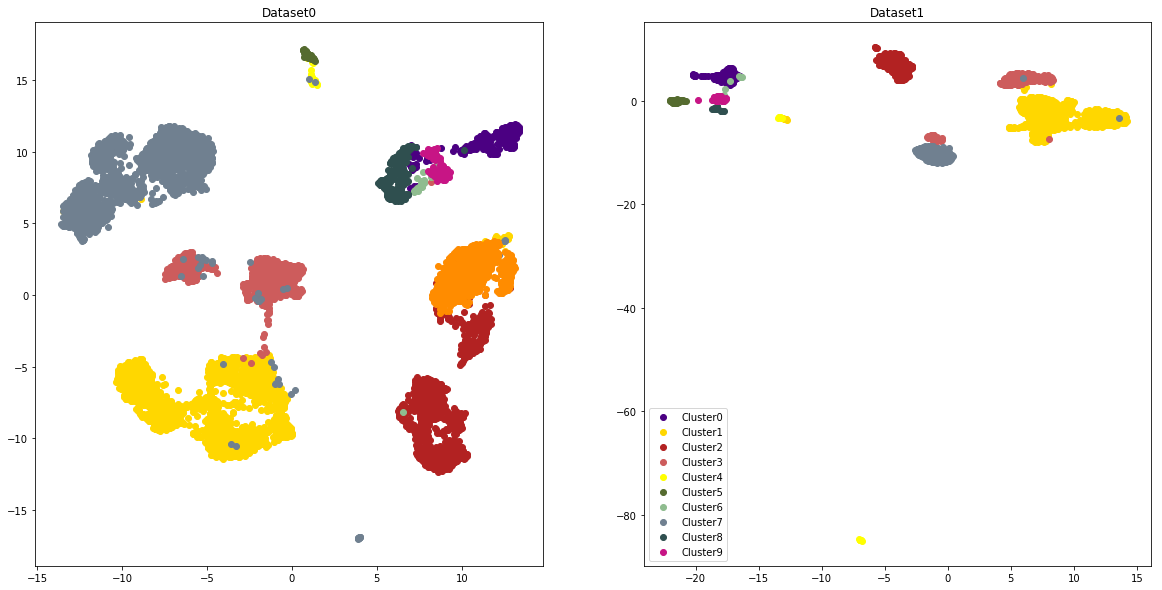

In [12]:
MSingle.Umap_Result()

# Output PopCorn results into a file

In [13]:
FileName = "scPopCorn_Human_Mouse_Pan_Reprodcue_Result.txt"
MSingle.OutputResult(FileName)